# Cycling to work - a data fitting challenge
I am an avid cyclist, and ride to work every day rain or shine (though hail can make me call my wife to pick me up!). With access to census data in Australia I thought it would be interesting to see if I could fit a model to predict cyling to work based on other census factors. This insight could help town planners with making changes to encourage cycling to work.

# Problem Statement: 
I will aim to fit an ML model to census data to predict the proportion of people cycling to work using R2 regression as my evaluation metric. 

# First we need to import a number of libraries including our custom functions
There is some overlap in our plotting, but it's nice to be able to both make quick histograms of our data and to have more interactive versions using Bokeh

In [3]:
import importlib
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import os
from textwrap import wrap
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import eli5
import cleanfunc
import re
from sklearn.metrics import r2_score
from bokeh.models import HoverTool
from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
importlib.reload(cleanfunc)


<module 'cleanfunc' from 'C:\\Users\\cartechr\\OneDrive - Mars Inc\\GitHub\\ABS-Region-Data\\cleanfunc.py'>

We're going to just read in the pre-prepared data. Functions are included in cleanfunc.py to read the raw excel files you can get from the ABS, but this can take significant time to process, so we have exported the cleaned data for use here

In [4]:
df = pd.read_csv('df.csv', index_col = "LABEL")
df.head()


,NUMBER OF BUSINESSES Number of non-employing businesses no.,NUMBER OF BUSINESSES 1-4 employees no.,NUMBER OF BUSINESSES 5-19 employees no.,NUMBER OF BUSINESSES 20 or more employees no.,NUMBER OF BUSINESSES Total number of businesses no.,BUSINESS ENTRIES Number of non-employing business entries no.,BUSINESS ENTRIES 1-4 employees no.,BUSINESS ENTRIES 5-19 employees no.,BUSINESS ENTRIES 20 or more employees no.,BUSINESS ENTRIES Total number of business entries no.,...,RELIGIOUS AFFILIATION Judaism %,RELIGIOUS AFFILIATION Other Religions %,"RELIGIOUS AFFILIATION Secular Beliefs, Other Spiritual Beliefs and No Religious Affiliation %",RELIGIOUS AFFILIATION Inadequately described or not stated %,AUSTRALIAN CITIZENSHIP Australian citizen %,AUSTRALIAN CITIZENSHIP Not an Australian citizen %,AUSTRALIAN CITIZENSHIP Australian Citizenship - Not stated %,SPEAKS A LANGUAGE OTHER THAN ENGLISH AT HOME Proportion of total population %,lat,long
LABEL,,,,,,,,,,,,,,,,,,,,,
Queanbeyan,402.0,193.0,89.0,27.0,712.0,75.0,32.0,5.0,3.855263,111.0,...,0.100000,2.1,28.5,10.5,80.6,11.2,8.2,21.2,-35.352466,149.233725
Wyong,322.0,193.0,85.0,23.0,631.0,40.0,34.0,7.0,3.855263,84.0,...,0.100000,0.7,28.6,9.4,86.1,6.3,7.6,8.2,-33.285641,151.425306
Bathurst,1017.0,574.0,254.0,58.0,1895.0,122.0,80.0,12.0,3.000000,211.0,...,0.100000,0.4,24.0,12.0,86.2,4.0,9.9,4.9,-33.474707,149.641320
Orange,983.0,515.0,270.0,61.0,1832.0,119.0,60.0,10.0,3.855263,196.0,...,0.748598,0.4,22.6,9.7,88.1,3.8,8.0,5.3,-33.329242,149.108147
Maitland,836.0,277.0,114.0,18.0,1241.0,132.0,38.0,8.0,3.855263,172.0,...,0.100000,0.6,26.7,9.8,89.1,3.5,7.4,3.8,-32.708177,151.526844


We're interested in looking at the cycling data. There are a number of different region sizes, so it makes sense to normalise the cyclists by the number of households in an area.

The value we are trying to predict (y) is then this column. We should drop this column from our original dataframe to create X

In [5]:
cycle_col = 'METHOD OF TRAVEL TO WORK - EMPLOYED PERSONS Used one method - Bicycle no.'
residents_col = 'ESTIMATED RESIDENT POPULATION (USUAL RESIDENTS, ERP AT 30 JUNE)  Total no.'
y = df[cycle_col]/df[residents_col]
y.index = df.index
X = df.drop([cycle_col, residents_col], axis = 1)


Let's visually explore our data to see what we're working with

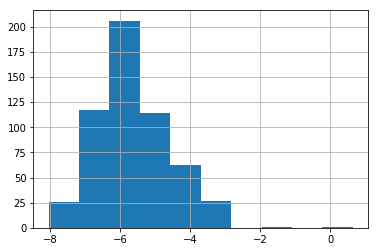

In [6]:
np.log(y).hist()


We have to plot with a log scale because the vast bulk of data is at the low end. There is also a couple of significant outliers at the top that look like they might have to be removed

In [7]:
print(df.loc[y>0.1,[cycle_col, residents_col]])
print("Median population of each region: {}".format(df[residents_col].median()))

                  METHOD OF TRAVEL TO WORK - EMPLOYED PERSONS Used one method - Bicycle no.  \
LABEL                                                                                         
Lord Howe Island                                          54.000000                           
Badgerys Creek                                            44.129032                           

                  ESTIMATED RESIDENT POPULATION (USUAL RESIDENTS, ERP AT 30 JUNE)  Total no.  
LABEL                                                                                         
Lord Howe Island                                              194.0                           
Badgerys Creek                                                 23.0                           
Median population of each region: 6445.0


Both of these outliers have extremely small resident population which when combined with a moderate number of cyclists gives an unusual result. We will drop both these points from our analysis

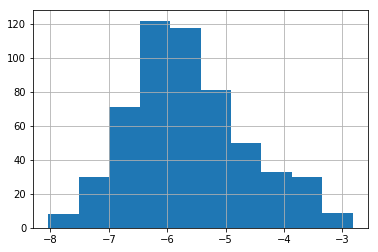

In [8]:
X = X[y<0.1]
y = y[y<0.1]

np.log(y).hist()


That's a little better, though we still have a significant cluster below the 1% mark. We might deal with that later.

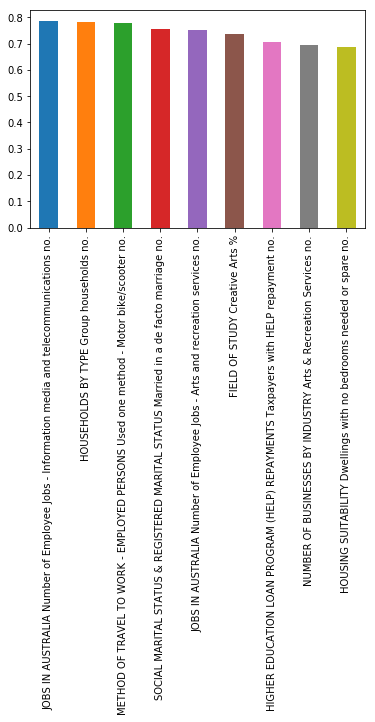

In [9]:
correlations = cleanfunc.sort_series_abs(df.dropna(subset=[cycle_col]
                         ).corr().loc[:,cycle_col])[1:10]

correlations.plot(kind='bar')

# Machine Learning - First Pass
Now that we have a clean dataframe, we would like to apply some machine learning to it to see if we can predict the number of cyclists. Once we can make predictions, we can interrogate those predictions to see what's going on.

In [10]:
y_binned = np.digitize(y, y.quantile([0, 0.2, 0.4, 0.6, 0.8]))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 43, stratify = y_binned)

In [11]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [12]:

y_pred, y_train_pred = cleanfunc.evaluate_model(rf, X_train, X_test, y_train, y_test)

Loading BokehJS ...

Train data R2 score: 0.9507424401437472
Test data R2 score: 0.5161265551169147


A 50% r2 score on out test data isn't too bad! But the fact that we're getting a 95% R2 score on our train data would suggest that we're over-fitting quite a bit. Let's do some grid-searching to see if we can improve this model

# Transforming data with a log function
I read recently on a kaggle kernal that many regressors do not perform as well on skewed data. I thought I would try transforming my Y though a log transform to approach a more normal distribution and fit a standard model. 

In [36]:
y_log = np.log(y)
y_log_binned = np.digitize(y_log, y_log.quantile([0, 0.2, 0.4, 0.6, 0.8]))
X_train, X_test, y_log_train, y_log_test = train_test_split(X, y_log, test_size = 0.2, random_state = 43, stratify = y_binned)
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_log_train)
y_log_pred, y_log_train_pred = cleanfunc.evaluate_model(rf, X_train, X_test, y_log_train, y_log_test)

Loading BokehJS ...

Train data R2 score: 0.9465196685576699
Test data R2 score: 0.48584481776086885


In [37]:
r2_score(np.exp(y_log_test), np.exp(y_log_pred))

0.5771450231915842

It is important to look at the un-transformed data R2 as the absolute values can have a significant effect. It looks like this improvement has increased our model R2 quite significantly. This is worth further exploration in the later parts of this notebook, but will be left for another time. 

# Machine Learning: Refinement:
There are a number of things we can do to refind our model, first we can do some hyper-parameter tuning using a random grid search. This will allow us to search a wide section of parameters in a relatively shorter time. 

In [13]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [14]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.7min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [15]:
print(rf_random.best_params_)
best_random = rf_random.best_estimator_


{'n_estimators': 180, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}


In [16]:
y_best_pred, y_best_train_pred = cleanfunc.evaluate_model(best_random, X_train, X_test, y_train, y_test)

Loading BokehJS ...

Train data R2 score: 0.9433647854229724
Test data R2 score: 0.5211060425740528


Compared to our old R2 score of 0.50 we have a 2% increase. Not a lot, but it's something! Mousing over the higher values shows that a large number of them are in inner sydney. The bulk of the values are below 2% cyclists. I wonder if the model is being overwhelmed by signal at the high end, meaning it isn't picking up the more subtle signals at the low end. I'm going to recut the dataframe and rebuild our analysis to check.

In [17]:
percentbelow = 2
print('Proportion of data below {}% cyclists in region: {:0.2f}%'.format((percentbelow),100*sum(y_test<(percentbelow/100))/y_test.shape[0]))
print('Test data R2 score for values below {}% cyclists in region: {:0.2f}'.format(percentbelow, r2_score(y_test[y_test<(percentbelow/100)], y_best_pred[y_test<(percentbelow/100)])))


Proportion of data below 2% cyclists in region: 95.50%
Test data R2 score for values below 2% cyclists in region: -0.04


With an R2 value which is negative, we can see that our model is worse than simply taking the average of the data at predicting low end values. Given that this subset holds nearly 85% of all our data, this is definitely something we want to address

In [18]:
y_trunc = y[y<0.02]
X_trunc = X[y<0.02]

We can now reuse our code from earlier to process and graph the data.

In [19]:
y_binned = np.digitize(y_trunc, y_trunc.quantile([0, 0.2, 0.4, 0.6, 0.8]))
X_trunc_train, X_trunc_test, y_trunc_train, y_trunc_test = train_test_split(X_trunc, y_trunc, test_size = 0.2, random_state = 43, stratify = y_binned)

In [20]:
rf_trunc = RandomForestRegressor(n_estimators=200)
rf_trunc.fit(X_trunc_train, y_trunc_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [21]:
y_best_pred, y_best_train_pred = cleanfunc.evaluate_model(rf_trunc, X_trunc_train, X_trunc_test, y_trunc_train, y_trunc_test)

Loading BokehJS ...

Train data R2 score: 0.9038103479109401
Test data R2 score: 0.46662873428427754


Let's look at the correlations in this dataset

In [22]:
perm = eli5.sklearn.PermutationImportance(rf_trunc).fit(X_trunc_test, y_trunc_test)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.0413 ± 0.0227,COMMUTING TO WORK Average commuting distance from Place of Usual Residence kms
0.0404 ± 0.0094,COMMUTING TO WORK Median commuting distance from Place of Usual Residence kms
0.0216 ± 0.0518,METHOD OF TRAVEL TO WORK - EMPLOYED PERSONS Used one method - Motor bike/scooter no.
0.0124 ± 0.0090,FIELD OF STUDY Creative Arts %
0.0088 ± 0.0082,long
0.0074 ± 0.0050,"RELIGIOUS AFFILIATION Secular Beliefs, Other Spiritual Beliefs and No Religious Affiliation %"
0.0063 ± 0.0068,HOUSEHOLDS BY TYPE Lone person households no.
0.0061 ± 0.0036,METHOD OF TRAVEL TO WORK - EMPLOYED PERSONS Used one method - Walked only no.
0.0058 ± 0.0084,NUMBER OF BUSINESSES BY INDUSTRY Accommodation & Food Services no.
0.0058 ± 0.0010,"ESTIMATED RESIDENT POPULATION (USUAL RESIDENTS, ERP AT 30 JUNE) 40-44 years no."


In [23]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_trunc = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random_trunc.fit(X_trunc_train, y_trunc_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.9min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [25]:
print(rf_random.best_params_)
best_trunc = rf_random_trunc.best_estimator_
y_best_pred, y_best_train_pred = cleanfunc.evaluate_model(best_trunc, X_trunc_train, X_trunc_test, y_trunc_train, y_trunc_test)

{'n_estimators': 180, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}


Loading BokehJS ...

Train data R2 score: 0.8865518134288911
Test data R2 score: 0.49777998191972583


In [26]:

lower_bound = 0.004
upper_bound = 0.03

y_trunc = y[(y<upper_bound) & (y > lower_bound)]
X_trunc = X[(y<upper_bound) & (y > lower_bound)]

In [27]:
rf_trunc = RandomForestRegressor(n_estimators=200)
rf_trunc.fit(X_trunc_train, y_trunc_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [28]:
y_low_pred, y_low_train_pred = cleanfunc.evaluate_model(rf_trunc, X_trunc_train, X_trunc_test, y_trunc_train, y_trunc_test)

Loading BokehJS ...

Train data R2 score: 0.906371203858099
Test data R2 score: 0.4611196740109156


Out of curiosity, how does our model trained on truncated data generalize to the full dataset

In [29]:
y_low_pred, y_low_train_pred = cleanfunc.evaluate_model(rf_trunc, X_train, X_test, y_train, y_test)

Loading BokehJS ...

Train data R2 score: 0.41855724967266705
Test data R2 score: 0.4923217123661374


It performs very poorly! It looks like we'll have to Use a multi-layer model, as the effects which dominate at the high end don't have as much of an impact at the low end. 

In [30]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_trunc = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random_trunc.fit(X_trunc_train, y_trunc_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.9min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [31]:
print(rf_random_trunc.best_params_)
best_trunc = rf_random_trunc.best_estimator_
y_best_pred, y_best_train_pred = cleanfunc.evaluate_model(best_trunc, X_trunc_train, X_trunc_test, y_trunc_train, y_trunc_test)

{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 90, 'bootstrap': True}


Loading BokehJS ...

Train data R2 score: 0.8866860107441148
Test data R2 score: 0.47286519126146676


Interestingly this model seems to have over-fit our train data a little worse, giving us an overall worse R2 score on our holdout set. 

# Combining models
For the final step we're going to try combining a variety of models to maintain accuracy at all levels

In [32]:
y_binned = np.digitize(y, y.quantile([0, 0.2, 0.4, 0.6, 0.8]))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 43, stratify = y_binned)

X_strat = []
forests = []
ranges = [[0,0.02], [0.0, 1]]
for minmax in ranges:
    print(minmax)
    y_trunc = y_train[(y>minmax[0]) & (y<minmax[1])]
    X_trunc = X_train[(y>minmax[0]) & (y<minmax[1])]
    print(y_trunc.shape)
    print(X_trunc.shape)
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X_trunc, y_trunc)
    forests.append(rf)
    
print(forests)

[0, 0.02]
(405,)
(405, 453)


C:\Users\cartechr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


[0.0, 1]
(441,)
(441, 453)


C:\Users\cartechr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


[RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False), RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)]


In [33]:
predictions = pd.DataFrame(data={})
for i, rf in enumerate(forests):
    y_pred = rf.predict(X_test)
    predictions = pd.concat([predictions, pd.DataFrame(y_pred)], axis = 1)
predictions.head()

,0,0
0,0.001284,0.001295
1,0.010356,0.010249
2,0.003091,0.003012
3,0.002095,0.002289
4,0.001493,0.001533


In [34]:
predictions

def chooseprediction(x):
    [low, high] = x
    prediction = high
    if prediction < 0.02:
        prediction = low
    return prediction

def multipredict(forests):
    
    predictions = pd.DataFrame(data={})
    for i, rf in enumerate(forests):
        y_pred = rf.predict(X_test)
        predictions = pd.concat([predictions, pd.DataFrame(y_pred)], axis = 1)
    

        
    prediction = predictions.apply(chooseprediction, axis = 1)
    
    return prediction

y_pred_multi = multipredict(forests)

In [35]:
test_source = ColumnDataSource(data=dict(
    x=y_test,
    y=y_pred_multi,
    desc=y_test.index,
))
hover = HoverTool()

p = figure(plot_width = 600, plot_height = 400, x_axis_label = 'Acutal', y_axis_label = 'Prediction')

p.circle('x', 'y', size=20, color = 'navy', alpha = 0.5, source = test_source, legend = 'Test Data')
p.line([0,max(y_test)],[0, max(y_test)], legend = 'line of perfect fit')
hover.tooltips = [
    ("index", '$index'),
    ("(x,y)", "($x, $y)"),
    ("desc", "@desc"),
]

p.tools.append(hover)
p.legend.location = 'top_left'
p.legend.click_policy="hide"
p.toolbar.logo = None
p.toolbar_location = None
show(p)
print("Test data R2 score: {}".format(r2_score(y_test, y_pred_multi)))


Test data R2 score: 0.4703469722242435


# Results

We can see with our combined model we have achieved an R2 value of 57%. This is a modest improvement on our first pass of 49% so we can be happy with our work. Particularly, by using a multi-layer randomforest we can get much better granularity at the lower end of the function. This area may not have a huge impact on the overall R2 score, as it tends to get "swamped" by the data at the high end, but it can be extremely helpful to know what drives cycling uptake at the low end. 